In [1]:
import pandas as pd
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import matplotlib.pyplot as plt
from transformers import DetrFeatureExtractor
import torch
import cv2
import os
import glob
from pathlib import Path

2023-05-11 17:51:12.698955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 17:51:12.827446: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-11 17:51:14.208764: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/leuven/icelake/2021a/software/CUDA/11.7.1/nvvm/lib64:/apps/leuven/icelake/2021a/s

In [63]:
MODEL_NAME = "nlpconnect/vit-gpt2-image-captioning"
input_dir = Path().resolve() / 'IMAGE_INPUT_PATH'
output_dir = Path().resolve()/ 'IMAGE_OUTPUT_PATH'

In [3]:
print(input_dir)

/vsc-hard-mounts/leuven-data/351/vsc35135/cv_and_nlp/IMAGE_INPUT_PATH


Analyzing image /vsc-hard-mounts/leuven-data/351/vsc35135/cv_and_nlp/IMAGE_INPUT_PATH/GOPR0637.JPG


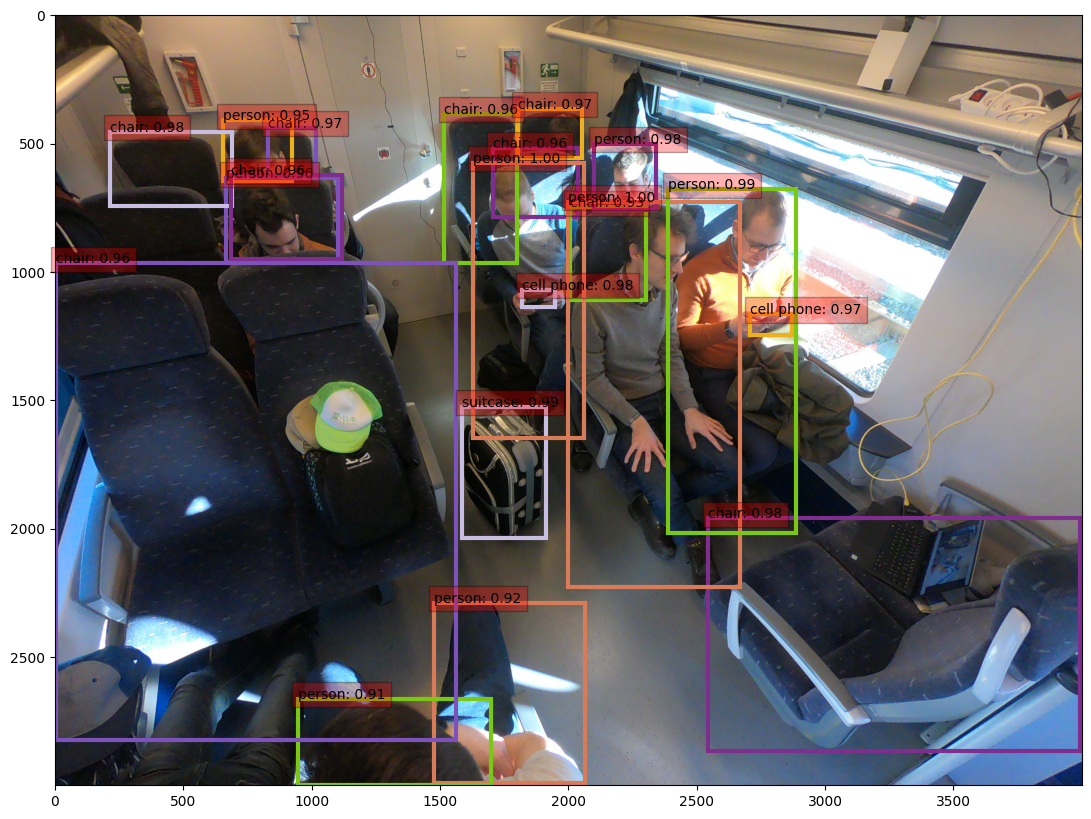

In [7]:
# Load DETR model
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Loop through input images
for image_path in glob.glob(os.path.join(input_dir, "*.JPG")):
    
    print(f"Analyzing image {image_path}")
    
    # Load image
    image = Image.open(image_path)

    # Extract image features
    inputs = feature_extractor(image, return_tensors="pt")
    inputs.keys()
    
    outputs = model(**inputs)
    
    col = [[0.494, 0.184, 0.556], [0.484, 0.779, 0.088], [0.784, 0.745, 0.888],
              [0.492, 0.323, 0.732], [0.849, 0.484, 0.348], [0.929, 0.694, 0.125]]

    # keep bounding boxes with a 0.90 threshold
    probability = outputs.logits.softmax(-1)[0, :, :-1]
    threshold = probability.max(-1).values > 0.90

    # rescale 
    size = torch.tensor(image.size[::-1]).unsqueeze(0)
    output_after = feature_extractor.post_process(outputs, size)
    bounding_boxes = output_after[0]['boxes'][threshold]
    
    #plot result
    img_name = os.path.basename(image_path).split('.')[0] + ".JPG"
    img_path = os.path.join(output_dir, img_name)
    
    plot_image(image, probability[threshold], bounding_boxes, img_path)

Analyzing image /vsc-hard-mounts/leuven-data/351/vsc35135/cv_and_nlp/IMAGE_INPUT_PATH/GOPR0637.JPG


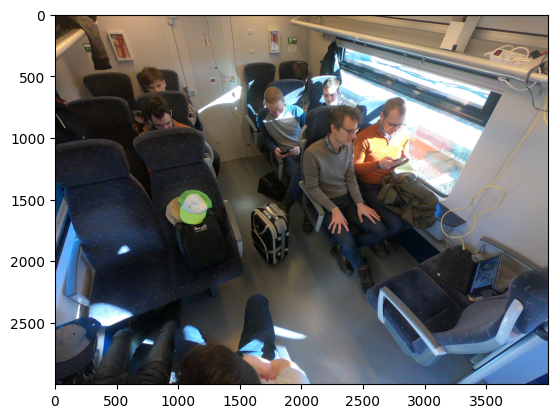

person detected


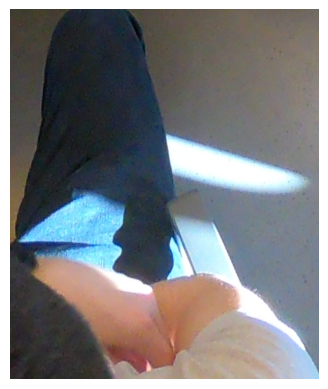

person detected


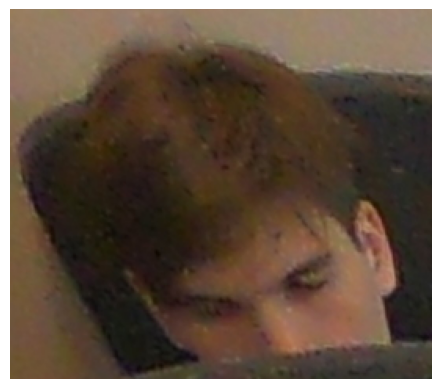

person detected


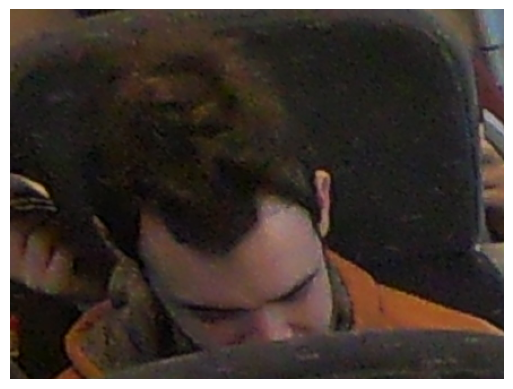

person detected


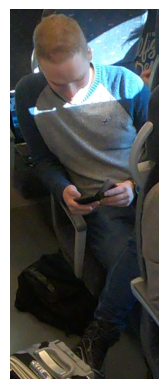

person detected


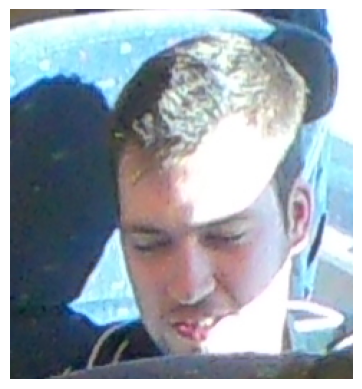

person detected


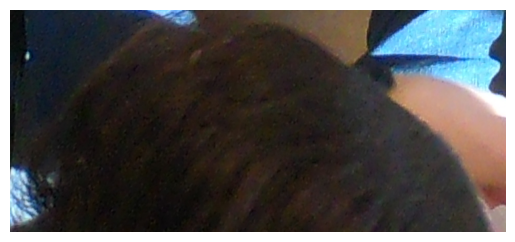

person detected


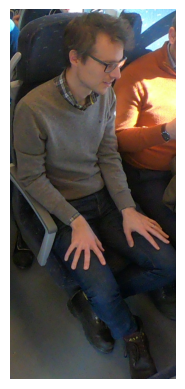

person detected


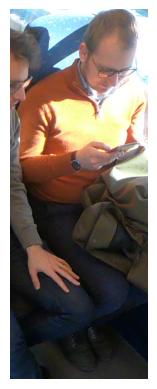

In [8]:
# Load DETR model
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# Loop through input images
for image_path in glob.glob(os.path.join(input_dir, "*.JPG")):
    
    print(f"Analyzing image {image_path}")
    
    # Load image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()
    
    # Extract image features
    inputs = feature_extractor(image, return_tensors="pt")
    inputs.keys()
    
    outputs = model(**inputs)
    
    col = [[0.494, 0.184, 0.556], [0.484, 0.779, 0.088], [0.784, 0.745, 0.888],
              [0.492, 0.323, 0.732], [0.849, 0.484, 0.348], [0.929, 0.694, 0.125]]
    
    color = col * 100
    
    # keep bounding boxes with a 0.90 threshold
    probability = outputs.logits.softmax(-1)[0, :, :-1]
    threshold = probability.max(-1).values > 0.90

    # rescale 
    size = torch.tensor(image.size[::-1]).unsqueeze(0)
    output_after = feature_extractor.post_process(outputs, size)
    bounding_boxes = output_after[0]['boxes'][threshold]
    
    # plot result
    img_name = os.path.basename(image_path).split('.')[0] + ".JPG"
    img_path = os.path.join(output_dir, img_name)
    
    # plot_image(image, probability[threshold], bounding_boxes, img_path)
    
    boxnumber = len(bounding_boxes)

    label = image_boxes(image, probability[threshold], bounding_boxes)
    
    image = cv2.imread(image_path)
    
    for i in range(0, len(label)):
        if label[i] == "person": 
            print("person detected")
            X, Y, W, H = bounding_boxes[i].int()
            coordinates = image[Y:H, X:W]
            coordinates = cv2.cvtColor(coordinates, cv2.COLOR_BGR2RGB)
            plt.imshow(coordinates)
            img = f'{i}_{label[i]}.JPG'
            
            img_path = os.path.basename(image_path)+ img
            img_path_boxes = os.path.join(output_dir, img_path)
            plt.axis('off')
            plt.savefig(img_path_boxes)
            plt.show()

In [9]:
from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel

In [64]:
image_processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_NAME)

In [65]:
MODEL_NAME = Path().resolve() / 'training' / 'retrainedepoch_5'
assert MODEL_NAME.exists()
model = VisionEncoderDecoderModel.from_pretrained(MODEL_NAME)

In [66]:
# GPT2 only has bos/eos tokens but not decoder_start/pad tokens
tokenizer.pad_token = tokenizer.eos_token

# update the model config
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [67]:
i_images = []

for image in os.listdir(output_dir):
    full_image_path = output_dir / image
    if not str(full_image_path).endswith("ipynb_checkpoints"):
        print(image)
        i_image = Image.open(full_image_path)
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode="RGB")
        i_images.append(i_image)
pixel_values = image_processor(images=i_images, return_tensors="pt").pixel_values

Cat_November_2010-1a.jpg
GOPR0637.JPG4_person.JPG
GOPR0637.JPG5_person.JPG
GOPR0637.JPG9_person.JPG
GOPR0637.JPG10_person.JPG
GOPR0637.JPG12_person.JPG
GOPR0637.JPG13_person.JPG
GOPR0637.JPG16_person.JPG
GOPR0637.JPG19_person.JPG


In [68]:
pixel_values.shape

torch.Size([9, 3, 224, 224])

In [69]:
model_kwargs = {"max_new_tokens": 45}
output_ids = model.generate(pixel_values=pixel_values, **model_kwargs)

In [70]:
output_ids.shape

torch.Size([9, 33])

In [71]:
for x in output_ids:
    print(x)
predictions = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

tensor([50256,   464,  2415,   318,  5762,   257,  2042, 13209,   290,   257,
         2042, 22526,    13,  1375,   318,  6155,   319,   262,  2975,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256])
tensor([50256,   464,  2415,   318,  5762,   257,  2042, 13209,   290,   257,
         2042, 22526,    13,  1375,   318,  6155,   319,   262,  2975,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256])
tensor([50256,   464,  2415,   287,   262,  4171, 13209,   318,  6155,   319,
          262,  2975,   351,   607,  2832,   287,   607, 16511,   220, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256])
tensor([50256,   464,  2415,   287,   262,  2042, 13209,   318,  5762,   257,
         2042, 13209,   290,   257,  2042, 22526,    13,  1375,   318,  5762,
          257,  2042, 15224,   290,   257,  2042, 36

In [72]:
predictions

['The woman is wearing a black coat and a black backpack. She is walking on the road.',
 'The woman is wearing a black coat and a black backpack. She is walking on the road.',
 'The woman in the blue coat is walking on the road with her hands in her pockets ',
 'The woman in the black coat is wearing a black coat and a black backpack. She is wearing a black jacket and a black scarf.',
 'The woman in the dress is wearing a black suit and a white tie ',
 'The woman in the blue coat is walking on the road. She is wearing a black jacket and a pair of black shoes.',
 'The woman in the dress is wearing a black coat and a black tie. She is wearing a black jacket and a black backpack.',
 'The woman in the dress is wearing a black coat and a black tie ',
 'The woman in the blue coat is wearing a black jacket and a pair of black shoes. She is wearing a black hat and a pair of black shoes.']

In [5]:
#function to plot DETR results
def image_boxes(image, probability, bounding_boxes):
    #rescale to avoid imagesize error
    #plt.figure(figsize=(16,10))
    #plt.imshow(image)
    
    #get current axis
    axis = plt.gca()
    
    #assigns label right above the box
    colors = col * 100
    
    label = []
    
    for p, (x_min, y_min, x_max, y_max), c in zip(probability, bounding_boxes.tolist(), colors):
        
        #add rectangle around tensor defined
        #axis.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   #fill=False, color=c, linewidth=3))
        
        cl = p.argmax()
        
        text = model.config.id2label[cl.item()]
        
        label.append(text)
        

    return label

In [6]:
#function to plot DETR results
def plot_image(image, probability, bounding_boxes, save_path = None):
    #rescale to avoid imagesize error
    plt.figure(figsize=(16,10))
    plt.imshow(image)
    
    #get current axis
    axis = plt.gca()
    
    #assigns label right above the box
    colors = col * 100

    for p, (x_min, y_min, x_max, y_max), c in zip(probability, bounding_boxes.tolist(), colors):
        
        #add rectangle around tensor defined
        axis.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   fill=False, color=c, linewidth=3))
        
        cl = p.argmax()
        text = f'{model.config.id2label[cl.item()]}: {p[cl]:0.2f}'
        axis.text(x_min, y_min, text, fontsize=10, bbox=dict(facecolor='red', alpha=0.3))
        
    #save_path
    if save_path is not None:
        plt.savefig(save_path)
        
    plt.show()